In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import anndata as an
import scanpy as sc 
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 

In [95]:
class ConvAutoencoder(nn.Module):
    def __init__(self, intermediate_ch):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, intermediate_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(intermediate_ch, intermediate_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(intermediate_ch, 1, 3, padding=1),
            nn.MaxPool1d(2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, intermediate_ch, 3, stride=2, padding=1),  # Output shape: (batch_size, 16, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, 1, 3, stride=1, padding=1),   # Output shape: (batch_size, 1, 50)
        )

    def forward(self, x, interpolate=True):
        inp_sd = x.size(-1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        if interpolate:
            x = F.interpolate(x, size=inp_sd)        
        
        return x
    
class ConvAutoencoderSmallerBottleneck(nn.Module):
    def __init__(self, intermediate_ch):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, intermediate_ch, 5, padding=0),
            nn.ReLU(),
            nn.Conv1d(intermediate_ch, intermediate_ch, 5, padding=0),
            nn.ReLU(),
            nn.Conv1d(intermediate_ch, 1, 5, padding=0),
            nn.MaxPool1d(3),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, intermediate_ch, 5, stride=2, padding=1),  # Output shape: (batch_size, 16, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, intermediate_ch, 5, stride=1, padding=1),   # Output shape: (batch_size, 1, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, 1, 5, stride=2, padding=1),   # Output shape: (batch_size, 1, 50)
        )

    def forward(self, x, interpolate=True):
        inp_sd = x.size(-1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        if interpolate:
            x = F.interpolate(x, size=inp_sd)        
        
        return x
    
class ConvAutoencoderTinyBottleneck(nn.Module):
    def __init__(self, intermediate_ch):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, intermediate_ch, 5, padding=0),
            nn.ReLU(),
            
            nn.Conv1d(intermediate_ch, intermediate_ch, 5, padding=0),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.Conv1d(intermediate_ch, intermediate_ch, 5, padding=0),
            nn.ReLU(),
            
            nn.Conv1d(intermediate_ch, 1, 5, padding=0),
            nn.MaxPool1d(2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, intermediate_ch, 5, stride=2, padding=0),  # Output shape: (batch_size, 16, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, intermediate_ch, 5, stride=1, padding=0),   # Output shape: (batch_size, 1, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, intermediate_ch, 5, stride=1, padding=0),   # Output shape: (batch_size, 1, 50)
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_ch, 1, 5, stride=2, padding=0),   # Output shape: (batch_size, 1, 50)
        )

    def forward(self, x, interpolate=True):
        inp_sd = x.size(-1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        if interpolate:
            x = F.interpolate(x, size=inp_sd)        
        
        return x

In [97]:
data = np.load("chip19894_cut.npy")

traindata = data[0:4000, :]
valdata = data[4000:, :]

class EphysDataset(Dataset):
    def __init__(self, data, normalize=True):
        self.data = data
        self.normalize = normalize
        
    def __getitem__(self, idx):
        sample = torch.as_tensor(self.data[idx, ...]).float()
        
        if self.normalize:
            sample = sample / torch.norm(sample)

        sample = sample.unsqueeze(0)
        
        return sample 
    
    def __len__(self):
        return len(self.data)
    
traindataset = EphysDataset(traindata)
valdatset = EphysDataset(valdata)

train_loader = DataLoader(traindataset, batch_size=8)
val_loader = DataLoader(valdatset, batch_size=8)

In [100]:
sample = next(iter(train_loader))

sample.shape

torch.Size([8, 1, 50])

In [101]:
intermediate_ch = 16

model = ConvAutoencoder(intermediate_ch)
model_smaller = ConvAutoencoderSmallerBottleneck(intermediate_ch)
model_tiny = ConvAutoencoderTinyBottleneck(intermediate_ch)

In [102]:
traindataset[0].max(), traindataset[0].min(), traindataset[0].mean()


(tensor(0.1743), tensor(-0.4530), tensor(0.0042))

In [103]:
def train_model(model, num_epochs=115):
    optim = torch.optim.AdamW(model.parameters(), 1e-5)
    criterion = nn.MSELoss()

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optim.zero_grad()
            outputs = model(data)

            loss = criterion(outputs, data)
            loss.backward()
            optim.step()

            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}")

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_outputs = model(val_data)
                val_loss = criterion(val_outputs, val_data)
                val_running_loss += val_loss.item() * val_data.size(0)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_epoch_loss}")

        # Early stopping check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= 3:
            print("Early stopping after", epoch+1, "epochs.")
            break


In [104]:
def get_results(model, dataloader):
    copy_model = deepcopy(model)
    val_results = []
    copy_model.eval()
    copy_model.decoder = nn.Identity()

    for sample in dataloader:
        output = copy_model(sample, interpolate=False).mean(1)
        val_results.append(output)
        
    print("Compressed dim is", output.size(-1))
    val_results = torch.cat(val_results).detach().numpy()
    
    return val_results

In [105]:
train_model(model)
train_model(model_smaller)
train_model(model_tiny)
train_model(model_mini)

Epoch 1/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 70.24it/s]


Epoch 1/115, Train Loss: 0.020105669613927603
Epoch 1/115, Val Loss: 0.019985099653808437


Epoch 2/115: 100%|██████████████████████████████████████| 500/500 [00:06<00:00, 82.29it/s]


Epoch 2/115, Train Loss: 0.019842040717601775
Epoch 2/115, Val Loss: 0.01944335035371537


Epoch 3/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 92.40it/s]


Epoch 3/115, Train Loss: 0.018017095822840928
Epoch 3/115, Val Loss: 0.016328898072242738


Epoch 4/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 95.45it/s]


Epoch 4/115, Train Loss: 0.014090217895805836
Epoch 4/115, Val Loss: 0.011854104382195035


Epoch 5/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 95.94it/s]


Epoch 5/115, Train Loss: 0.009426739051006734
Epoch 5/115, Val Loss: 0.007332313285038179


Epoch 6/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 94.89it/s]


Epoch 6/115, Train Loss: 0.005585593367461115
Epoch 6/115, Val Loss: 0.0041980180167117895


Epoch 7/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 89.24it/s]


Epoch 7/115, Train Loss: 0.003403006230480969
Epoch 7/115, Val Loss: 0.00273778373375535


Epoch 8/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 90.74it/s]


Epoch 8/115, Train Loss: 0.0025363803210202603
Epoch 8/115, Val Loss: 0.0022141225645508694


Epoch 9/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 99.65it/s]


Epoch 9/115, Train Loss: 0.0021561343299690634
Epoch 9/115, Val Loss: 0.0019569249538590712


Epoch 10/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 93.95it/s]


Epoch 10/115, Train Loss: 0.0019042514917673543
Epoch 10/115, Val Loss: 0.0017853720740852307


Epoch 11/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.39it/s]


Epoch 11/115, Train Loss: 0.001716976606170647
Epoch 11/115, Val Loss: 0.0016592077316944392


Epoch 12/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.51it/s]


Epoch 12/115, Train Loss: 0.0015681596405338497
Epoch 12/115, Val Loss: 0.001552879917958029


Epoch 13/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 83.21it/s]


Epoch 13/115, Train Loss: 0.00144647665519733
Epoch 13/115, Val Loss: 0.0014707291142406816


Epoch 14/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.20it/s]


Epoch 14/115, Train Loss: 0.0013302156488643959
Epoch 14/115, Val Loss: 0.0013372098720556467


Epoch 15/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 92.58it/s]


Epoch 15/115, Train Loss: 0.0012134646066115239
Epoch 15/115, Val Loss: 0.0012469945489714037


Epoch 16/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 83.19it/s]


Epoch 16/115, Train Loss: 0.0011029427338507959
Epoch 16/115, Val Loss: 0.0011328764606685358


Epoch 17/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.89it/s]


Epoch 17/115, Train Loss: 0.001011661766679026
Epoch 17/115, Val Loss: 0.001057513112116757


Epoch 18/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 75.21it/s]


Epoch 18/115, Train Loss: 0.0009315828527905978
Epoch 18/115, Val Loss: 0.0009826949761933361


Epoch 19/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.87it/s]


Epoch 19/115, Train Loss: 0.0008555589214665815
Epoch 19/115, Val Loss: 0.0009077815852146975


Epoch 20/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 61.30it/s]


Epoch 20/115, Train Loss: 0.0007830413220799528
Epoch 20/115, Val Loss: 0.0008332471195750927


Epoch 21/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 79.55it/s]


Epoch 21/115, Train Loss: 0.0007141010664636269
Epoch 21/115, Val Loss: 0.0007598305650872692


Epoch 22/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 79.13it/s]


Epoch 22/115, Train Loss: 0.0006489469239604659
Epoch 22/115, Val Loss: 0.0006888640823545961


Epoch 23/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 74.25it/s]


Epoch 23/115, Train Loss: 0.0005878046384605114
Epoch 23/115, Val Loss: 0.0006214054047168062


Epoch 24/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 78.44it/s]


Epoch 24/115, Train Loss: 0.0005308550118352287
Epoch 24/115, Val Loss: 0.0005583373323672127


Epoch 25/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 93.08it/s]


Epoch 25/115, Train Loss: 0.00047799226047936827
Epoch 25/115, Val Loss: 0.0004986800978017249


Epoch 26/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 100.44it/s]


Epoch 26/115, Train Loss: 0.00042888769210549073
Epoch 26/115, Val Loss: 0.00044610583548890237


Epoch 27/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 104.83it/s]


Epoch 27/115, Train Loss: 0.00038592795701697467
Epoch 27/115, Val Loss: 0.0004014442996739657


Epoch 28/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.48it/s]


Epoch 28/115, Train Loss: 0.000348770878452342
Epoch 28/115, Val Loss: 0.0003642635106950124


Epoch 29/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 74.44it/s]


Epoch 29/115, Train Loss: 0.0003173740758938948
Epoch 29/115, Val Loss: 0.0003339048533828701


Epoch 30/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 101.14it/s]


Epoch 30/115, Train Loss: 0.0002913776770001277
Epoch 30/115, Val Loss: 0.0003092098966293151


Epoch 31/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 105.68it/s]


Epoch 31/115, Train Loss: 0.00026981284747307655
Epoch 31/115, Val Loss: 0.0002886843611605047


Epoch 32/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 95.30it/s]


Epoch 32/115, Train Loss: 0.00025173432372685054
Epoch 32/115, Val Loss: 0.00027163185764873896


Epoch 33/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 90.13it/s]


Epoch 33/115, Train Loss: 0.00023638252684031612
Epoch 33/115, Val Loss: 0.00025717962057477013


Epoch 34/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 92.12it/s]


Epoch 34/115, Train Loss: 0.00022235216182889416
Epoch 34/115, Val Loss: 0.00024366096310716654


Epoch 35/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 94.46it/s]


Epoch 35/115, Train Loss: 0.00021011472222744488
Epoch 35/115, Val Loss: 0.00023274134499453274


Epoch 36/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 99.06it/s]


Epoch 36/115, Train Loss: 0.00019992566862492823
Epoch 36/115, Val Loss: 0.000223680368739855


Epoch 37/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 105.08it/s]


Epoch 37/115, Train Loss: 0.0001913257404085016
Epoch 37/115, Val Loss: 0.00021588943963419


Epoch 38/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 109.19it/s]


Epoch 38/115, Train Loss: 0.00018397862194979096
Epoch 38/115, Val Loss: 0.00020904213852933324


Epoch 39/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 105.00it/s]


Epoch 39/115, Train Loss: 0.00017761093985609478
Epoch 39/115, Val Loss: 0.0002029861154555039


Epoch 40/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 109.03it/s]


Epoch 40/115, Train Loss: 0.0001721216493533575
Epoch 40/115, Val Loss: 0.00019763982531077667


Epoch 41/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 95.55it/s]


Epoch 41/115, Train Loss: 0.00016737000524881296
Epoch 41/115, Val Loss: 0.00019284233787068527


Epoch 42/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 104.60it/s]


Epoch 42/115, Train Loss: 0.0001631802416231949
Epoch 42/115, Val Loss: 0.00018856470634666633


Epoch 43/115: 100%|████████████████████████████████████| 500/500 [00:04<00:00, 111.16it/s]


Epoch 43/115, Train Loss: 0.00015942254606488858
Epoch 43/115, Val Loss: 0.00018469690839992837


Epoch 44/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 96.65it/s]


Epoch 44/115, Train Loss: 0.00015601399638399017
Epoch 44/115, Val Loss: 0.00018115241647156298


Epoch 45/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 94.54it/s]


Epoch 45/115, Train Loss: 0.0001528996513734455
Epoch 45/115, Val Loss: 0.00017794356031024982


Epoch 46/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.18it/s]


Epoch 46/115, Train Loss: 0.0001500837565108668
Epoch 46/115, Val Loss: 0.00017505673292492118


Epoch 47/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 92.58it/s]


Epoch 47/115, Train Loss: 0.00014754526336037088
Epoch 47/115, Val Loss: 0.00017247822762904118


Epoch 48/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.41it/s]


Epoch 48/115, Train Loss: 0.00014525933296681613
Epoch 48/115, Val Loss: 0.00017019088260653638


Epoch 49/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.62it/s]


Epoch 49/115, Train Loss: 0.0001431903477059677
Epoch 49/115, Val Loss: 0.00016809305047250486


Epoch 50/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 80.49it/s]


Epoch 50/115, Train Loss: 0.00014130337166716345
Epoch 50/115, Val Loss: 0.00016616086105219734


Epoch 51/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 75.08it/s]


Epoch 51/115, Train Loss: 0.00013955300375528167
Epoch 51/115, Val Loss: 0.00016437429554311427


Epoch 52/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.36it/s]


Epoch 52/115, Train Loss: 0.0001379114654409932
Epoch 52/115, Val Loss: 0.000162675097134506


Epoch 53/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.01it/s]


Epoch 53/115, Train Loss: 0.00013634795263351408
Epoch 53/115, Val Loss: 0.00016107981206673407


Epoch 54/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 91.06it/s]


Epoch 54/115, Train Loss: 0.00013484954712475884
Epoch 54/115, Val Loss: 0.00015954462994289187


Epoch 55/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 95.74it/s]


Epoch 55/115, Train Loss: 0.00013339592010015621
Epoch 55/115, Val Loss: 0.0001580409003880198


Epoch 56/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.94it/s]


Epoch 56/115, Train Loss: 0.0001319738329621032
Epoch 56/115, Val Loss: 0.00015656851663857662


Epoch 57/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 76.20it/s]


Epoch 57/115, Train Loss: 0.00013054514292161912
Epoch 57/115, Val Loss: 0.0001550986931649778


Epoch 58/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 79.95it/s]


Epoch 58/115, Train Loss: 0.0001290997613032232
Epoch 58/115, Val Loss: 0.0001536055600029483


Epoch 59/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 80.81it/s]


Epoch 59/115, Train Loss: 0.00012765745165233965
Epoch 59/115, Val Loss: 0.0001520956075888089


Epoch 60/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 80.28it/s]


Epoch 60/115, Train Loss: 0.00012628518191195326
Epoch 60/115, Val Loss: 0.0001506605217196475


Epoch 61/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 77.83it/s]


Epoch 61/115, Train Loss: 0.0001250418877825723
Epoch 61/115, Val Loss: 0.00014932379536378217


Epoch 62/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 71.68it/s]


Epoch 62/115, Train Loss: 0.00012387456688884414
Epoch 62/115, Val Loss: 0.00014807530473893966


Epoch 63/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 95.16it/s]


Epoch 63/115, Train Loss: 0.00012275362768559718
Epoch 63/115, Val Loss: 0.00014687655006573365


Epoch 64/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 96.32it/s]


Epoch 64/115, Train Loss: 0.0001216595838777721
Epoch 64/115, Val Loss: 0.00014572475108196864


Epoch 65/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 83.22it/s]


Epoch 65/115, Train Loss: 0.00012057951137830969
Epoch 65/115, Val Loss: 0.0001446408803196985


Epoch 66/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 93.88it/s]


Epoch 66/115, Train Loss: 0.00011951269929704722
Epoch 66/115, Val Loss: 0.00014356609664938167


Epoch 67/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 91.05it/s]


Epoch 67/115, Train Loss: 0.00011845814708067337
Epoch 67/115, Val Loss: 0.00014248107888436477


Epoch 68/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.24it/s]


Epoch 68/115, Train Loss: 0.00011740767956507625
Epoch 68/115, Val Loss: 0.00014138008975388236


Epoch 69/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 62.76it/s]


Epoch 69/115, Train Loss: 0.00011635210799431661
Epoch 69/115, Val Loss: 0.0001402857570703455


Epoch 70/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 78.64it/s]


Epoch 70/115, Train Loss: 0.0001152819137860206
Epoch 70/115, Val Loss: 0.00013916906642333167


Epoch 71/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.52it/s]


Epoch 71/115, Train Loss: 0.00011419187190767843
Epoch 71/115, Val Loss: 0.0001380428935850172


Epoch 72/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 81.05it/s]


Epoch 72/115, Train Loss: 0.00011308202080545016
Epoch 72/115, Val Loss: 0.00013685239385694684


Epoch 73/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.65it/s]


Epoch 73/115, Train Loss: 0.00011193185875890777
Epoch 73/115, Val Loss: 0.00013559161737675265


Epoch 74/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 58.29it/s]


Epoch 74/115, Train Loss: 0.00011073188337468309
Epoch 74/115, Val Loss: 0.00013428841414920778


Epoch 75/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.55it/s]


Epoch 75/115, Train Loss: 0.00010950872182002058
Epoch 75/115, Val Loss: 0.00013295504858786223


Epoch 76/115: 100%|█████████████████████████████████████| 500/500 [00:13<00:00, 35.77it/s]


Epoch 76/115, Train Loss: 0.00010827557122320286
Epoch 76/115, Val Loss: 0.00013163335620169052


Epoch 77/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 79.97it/s]


Epoch 77/115, Train Loss: 0.00010702920634139446
Epoch 77/115, Val Loss: 0.00013032848957144388


Epoch 78/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 91.05it/s]


Epoch 78/115, Train Loss: 0.00010584519447002094
Epoch 78/115, Val Loss: 0.0001291526528431711


Epoch 79/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 77.60it/s]


Epoch 79/115, Train Loss: 0.00010475430464430247
Epoch 79/115, Val Loss: 0.0001281736794430335


Epoch 80/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.44it/s]


Epoch 80/115, Train Loss: 0.00010379240733527694
Epoch 80/115, Val Loss: 0.00012737904501275863


Epoch 81/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.92it/s]


Epoch 81/115, Train Loss: 0.00010291134709768812
Epoch 81/115, Val Loss: 0.00012660169500586748


Epoch 82/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 64.27it/s]


Epoch 82/115, Train Loss: 0.00010206967429621727
Epoch 82/115, Val Loss: 0.00012584255091496743


Epoch 83/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.34it/s]


Epoch 83/115, Train Loss: 0.00010125598315426032
Epoch 83/115, Val Loss: 0.00012511128196801647


Epoch 84/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 76.47it/s]


Epoch 84/115, Train Loss: 0.00010046062200490269
Epoch 84/115, Val Loss: 0.00012439086139962382


Epoch 85/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 71.94it/s]


Epoch 85/115, Train Loss: 9.96805599788786e-05
Epoch 85/115, Val Loss: 0.0001236817553462413


Epoch 86/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 80.39it/s]


Epoch 86/115, Train Loss: 9.891397833052906e-05
Epoch 86/115, Val Loss: 0.00012298285308096806


Epoch 87/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.75it/s]


Epoch 87/115, Train Loss: 9.816020757716614e-05
Epoch 87/115, Val Loss: 0.0001222877336009073


Epoch 88/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.06it/s]


Epoch 88/115, Train Loss: 9.741542057236074e-05
Epoch 88/115, Val Loss: 0.00012159843445631998


Epoch 89/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 90.01it/s]


Epoch 89/115, Train Loss: 9.667903627996566e-05
Epoch 89/115, Val Loss: 0.00012089729495287151


Epoch 90/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.10it/s]


Epoch 90/115, Train Loss: 9.594324080171646e-05
Epoch 90/115, Val Loss: 0.00012017345229372838


Epoch 91/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.35it/s]


Epoch 91/115, Train Loss: 9.520218449324603e-05
Epoch 91/115, Val Loss: 0.0001194307597963453


Epoch 92/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 94.28it/s]


Epoch 92/115, Train Loss: 9.445450192652061e-05
Epoch 92/115, Val Loss: 0.0001186434845517304


Epoch 93/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 81.64it/s]


Epoch 93/115, Train Loss: 9.364547726727323e-05
Epoch 93/115, Val Loss: 0.00011774055946057625


Epoch 94/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.57it/s]


Epoch 94/115, Train Loss: 9.275797476584558e-05
Epoch 94/115, Val Loss: 0.0001168852633076758


Epoch 95/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 90.07it/s]


Epoch 95/115, Train Loss: 9.189760727167596e-05
Epoch 95/115, Val Loss: 0.00011611957196858997


Epoch 96/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.02it/s]


Epoch 96/115, Train Loss: 9.112924935834598e-05
Epoch 96/115, Val Loss: 0.00011545646420741758


Epoch 97/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.17it/s]


Epoch 97/115, Train Loss: 9.032887280773138e-05
Epoch 97/115, Val Loss: 0.00011472622667942957


Epoch 98/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.55it/s]


Epoch 98/115, Train Loss: 8.944501823498285e-05
Epoch 98/115, Val Loss: 0.00011398663723690444


Epoch 99/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.98it/s]


Epoch 99/115, Train Loss: 8.86041695412132e-05
Epoch 99/115, Val Loss: 0.00011328621780825304


Epoch 100/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 85.70it/s]


Epoch 100/115, Train Loss: 8.78586578546674e-05
Epoch 100/115, Val Loss: 0.00011262179574185546


Epoch 101/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 86.19it/s]


Epoch 101/115, Train Loss: 8.716413922593347e-05
Epoch 101/115, Val Loss: 0.00011196488746036823


Epoch 102/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 87.50it/s]


Epoch 102/115, Train Loss: 8.649829106434481e-05
Epoch 102/115, Val Loss: 0.00011129932433820558


Epoch 103/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 94.23it/s]


Epoch 103/115, Train Loss: 8.584534164401702e-05
Epoch 103/115, Val Loss: 0.00011063200882392489


Epoch 104/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 92.21it/s]


Epoch 104/115, Train Loss: 8.520303405748564e-05
Epoch 104/115, Val Loss: 0.00010996930919942797


Epoch 105/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 91.86it/s]


Epoch 105/115, Train Loss: 8.456836848199601e-05
Epoch 105/115, Val Loss: 0.00010931750992461516


Epoch 106/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 94.79it/s]


Epoch 106/115, Train Loss: 8.393958424130687e-05
Epoch 106/115, Val Loss: 0.00010867367351721088


Epoch 107/115: 100%|████████████████████████████████████| 500/500 [00:06<00:00, 72.45it/s]


Epoch 107/115, Train Loss: 8.331642721896059e-05
Epoch 107/115, Val Loss: 0.00010802639960590513


Epoch 108/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 84.29it/s]


Epoch 108/115, Train Loss: 8.270445002926862e-05
Epoch 108/115, Val Loss: 0.00010739588484581446


Epoch 109/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 88.39it/s]


Epoch 109/115, Train Loss: 8.210257741666283e-05
Epoch 109/115, Val Loss: 0.0001067777978964934


Epoch 110/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 85.27it/s]


Epoch 110/115, Train Loss: 8.150658835438663e-05
Epoch 110/115, Val Loss: 0.0001061595765869632


Epoch 111/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 86.11it/s]


Epoch 111/115, Train Loss: 8.09149299384444e-05
Epoch 111/115, Val Loss: 0.00010555394113239623


Epoch 112/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 88.82it/s]


Epoch 112/115, Train Loss: 8.032770733188954e-05
Epoch 112/115, Val Loss: 0.0001049497713823684


Epoch 113/115: 100%|████████████████████████████████████| 500/500 [00:06<00:00, 78.31it/s]


Epoch 113/115, Train Loss: 7.974655169527977e-05
Epoch 113/115, Val Loss: 0.0001043534323446006


Epoch 114/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.51it/s]


Epoch 114/115, Train Loss: 7.917053040728206e-05
Epoch 114/115, Val Loss: 0.00010377097565577394


Epoch 115/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 83.97it/s]


Epoch 115/115, Train Loss: 7.860033857286908e-05
Epoch 115/115, Val Loss: 0.00010320194327950772


Epoch 1/115: 100%|██████████████████████████████████████| 500/500 [00:08<00:00, 60.75it/s]


Epoch 1/115, Train Loss: 0.020832046926021575
Epoch 1/115, Val Loss: 0.019953706404384302


Epoch 2/115: 100%|██████████████████████████████████████| 500/500 [00:08<00:00, 62.22it/s]


Epoch 2/115, Train Loss: 0.019182007398456335
Epoch 2/115, Val Loss: 0.01844486816957289


Epoch 3/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 68.10it/s]


Epoch 3/115, Train Loss: 0.017409888356924058
Epoch 3/115, Val Loss: 0.016347879437463624


Epoch 4/115: 100%|██████████████████████████████████████| 500/500 [00:08<00:00, 62.02it/s]


Epoch 4/115, Train Loss: 0.014640680314972997
Epoch 4/115, Val Loss: 0.01301546934992075


Epoch 5/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 67.59it/s]


Epoch 5/115, Train Loss: 0.010809961484745145
Epoch 5/115, Val Loss: 0.008841835753041871


Epoch 6/115: 100%|██████████████████████████████████████| 500/500 [00:06<00:00, 71.59it/s]


Epoch 6/115, Train Loss: 0.006973356410861015
Epoch 6/115, Val Loss: 0.005492362315405388


Epoch 7/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 67.67it/s]


Epoch 7/115, Train Loss: 0.004262527002952993
Epoch 7/115, Val Loss: 0.0034165726128813564


Epoch 8/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 68.03it/s]


Epoch 8/115, Train Loss: 0.0027349953395314516
Epoch 8/115, Val Loss: 0.0024530254903116396


Epoch 9/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 69.78it/s]


Epoch 9/115, Train Loss: 0.0018923443335806952
Epoch 9/115, Val Loss: 0.0019298725386093162


Epoch 10/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.51it/s]


Epoch 10/115, Train Loss: 0.0013960631976369768
Epoch 10/115, Val Loss: 0.001611475186774089


Epoch 11/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.23it/s]


Epoch 11/115, Train Loss: 0.0010968423212179914
Epoch 11/115, Val Loss: 0.0014122456661425531


Epoch 12/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.61it/s]


Epoch 12/115, Train Loss: 0.0009103665651055053
Epoch 12/115, Val Loss: 0.0012720303549383749


Epoch 13/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.60it/s]


Epoch 13/115, Train Loss: 0.0007870286786346697
Epoch 13/115, Val Loss: 0.0011687160910306765


Epoch 14/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.85it/s]


Epoch 14/115, Train Loss: 0.0007054206220782362
Epoch 14/115, Val Loss: 0.0010965623883340432


Epoch 15/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.23it/s]


Epoch 15/115, Train Loss: 0.0006528378326911479
Epoch 15/115, Val Loss: 0.001044683419856984


Epoch 16/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 62.53it/s]


Epoch 16/115, Train Loss: 0.0006150018818443641
Epoch 16/115, Val Loss: 0.0010030871550600064


Epoch 17/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.94it/s]


Epoch 17/115, Train Loss: 0.0005844594489608425
Epoch 17/115, Val Loss: 0.0009680392800317127


Epoch 18/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 62.70it/s]


Epoch 18/115, Train Loss: 0.000557405148196267
Epoch 18/115, Val Loss: 0.0009358144479290563


Epoch 19/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.44it/s]


Epoch 19/115, Train Loss: 0.00053501323988894
Epoch 19/115, Val Loss: 0.0009091415304728613


Epoch 20/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 64.41it/s]


Epoch 20/115, Train Loss: 0.0005159486254851799
Epoch 20/115, Val Loss: 0.0008876274058319705


Epoch 21/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.20it/s]


Epoch 21/115, Train Loss: 0.0005002893592754845
Epoch 21/115, Val Loss: 0.0008692264201699243


Epoch 22/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 61.65it/s]


Epoch 22/115, Train Loss: 0.00048661904950859025
Epoch 22/115, Val Loss: 0.000853911088185613


Epoch 23/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.11it/s]


Epoch 23/115, Train Loss: 0.0004747854005836416
Epoch 23/115, Val Loss: 0.0008408201853649653


Epoch 24/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.36it/s]


Epoch 24/115, Train Loss: 0.00046430354320909826
Epoch 24/115, Val Loss: 0.000829199632054803


Epoch 25/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.86it/s]


Epoch 25/115, Train Loss: 0.0004547699000540888
Epoch 25/115, Val Loss: 0.0008184962176565765


Epoch 26/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 72.22it/s]


Epoch 26/115, Train Loss: 0.00044594488355505744
Epoch 26/115, Val Loss: 0.0008089248142656585


Epoch 27/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.31it/s]


Epoch 27/115, Train Loss: 0.00043776496504142415
Epoch 27/115, Val Loss: 0.0008003989464427553


Epoch 28/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.93it/s]


Epoch 28/115, Train Loss: 0.0004301324992411537
Epoch 28/115, Val Loss: 0.0007924120287572471


Epoch 29/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.94it/s]


Epoch 29/115, Train Loss: 0.0004230070481717121
Epoch 29/115, Val Loss: 0.000785107514405224


Epoch 30/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.36it/s]


Epoch 30/115, Train Loss: 0.0004163792561739683
Epoch 30/115, Val Loss: 0.0007784126028869947


Epoch 31/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.14it/s]


Epoch 31/115, Train Loss: 0.0004102262569940649
Epoch 31/115, Val Loss: 0.0007721782699987597


Epoch 32/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.49it/s]


Epoch 32/115, Train Loss: 0.00040443863428663463
Epoch 32/115, Val Loss: 0.0007662397395339509


Epoch 33/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 56.49it/s]


Epoch 33/115, Train Loss: 0.0003988800044171512
Epoch 33/115, Val Loss: 0.0007605760402226707


Epoch 34/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.32it/s]


Epoch 34/115, Train Loss: 0.00039329102922056335
Epoch 34/115, Val Loss: 0.0007551741446558462


Epoch 35/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.79it/s]


Epoch 35/115, Train Loss: 0.00038815828958468045
Epoch 35/115, Val Loss: 0.0007499034229038777


Epoch 36/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 64.96it/s]


Epoch 36/115, Train Loss: 0.0003833329732879065
Epoch 36/115, Val Loss: 0.0007448265275547319


Epoch 37/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.42it/s]


Epoch 37/115, Train Loss: 0.00037875371784321034
Epoch 37/115, Val Loss: 0.0007400197241270002


Epoch 38/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.90it/s]


Epoch 38/115, Train Loss: 0.00037437724025221543
Epoch 38/115, Val Loss: 0.0007351459303338613


Epoch 39/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.03it/s]


Epoch 39/115, Train Loss: 0.0003701815501262899
Epoch 39/115, Val Loss: 0.0007305414374319039


Epoch 40/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.10it/s]


Epoch 40/115, Train Loss: 0.0003661359162797453
Epoch 40/115, Val Loss: 0.0007259221051401477


Epoch 41/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.43it/s]


Epoch 41/115, Train Loss: 0.0003621404318109853
Epoch 41/115, Val Loss: 0.0007210794283903907


Epoch 42/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.95it/s]


Epoch 42/115, Train Loss: 0.000357919414062053
Epoch 42/115, Val Loss: 0.0007164292904662386


Epoch 43/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 71.17it/s]


Epoch 43/115, Train Loss: 0.000353912399354158
Epoch 43/115, Val Loss: 0.0007119398568851911


Epoch 44/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 71.58it/s]


Epoch 44/115, Train Loss: 0.0003502062034676783
Epoch 44/115, Val Loss: 0.0007075264106732698


Epoch 45/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 64.84it/s]


Epoch 45/115, Train Loss: 0.0003466131690511247
Epoch 45/115, Val Loss: 0.0007034547613905172


Epoch 46/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.66it/s]


Epoch 46/115, Train Loss: 0.000343098042125348
Epoch 46/115, Val Loss: 0.0006992583866920132


Epoch 47/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.78it/s]


Epoch 47/115, Train Loss: 0.00033964145072968677
Epoch 47/115, Val Loss: 0.0006952360428617887


Epoch 48/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 71.07it/s]


Epoch 48/115, Train Loss: 0.00033624875324312595
Epoch 48/115, Val Loss: 0.0006912469375066041


Epoch 49/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 71.16it/s]


Epoch 49/115, Train Loss: 0.00033290099889563864
Epoch 49/115, Val Loss: 0.0006873334018508808


Epoch 50/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.98it/s]


Epoch 50/115, Train Loss: 0.00032960536106838847
Epoch 50/115, Val Loss: 0.0006835399687347212


Epoch 51/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.67it/s]


Epoch 51/115, Train Loss: 0.00032635211187880485
Epoch 51/115, Val Loss: 0.0006797461045848928


Epoch 52/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.08it/s]


Epoch 52/115, Train Loss: 0.00032312196110433435
Epoch 52/115, Val Loss: 0.0006760770858892677


Epoch 53/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.46it/s]


Epoch 53/115, Train Loss: 0.0003199534263112582
Epoch 53/115, Val Loss: 0.0006723967653447382


Epoch 54/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.33it/s]


Epoch 54/115, Train Loss: 0.00031683291943045334
Epoch 54/115, Val Loss: 0.0006687763837232653


Epoch 55/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.42it/s]


Epoch 55/115, Train Loss: 0.0003137546967336675
Epoch 55/115, Val Loss: 0.0006652560421831108


Epoch 56/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.03it/s]


Epoch 56/115, Train Loss: 0.0003107318843831308
Epoch 56/115, Val Loss: 0.000661777558187688


Epoch 57/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.61it/s]


Epoch 57/115, Train Loss: 0.000307734120884561
Epoch 57/115, Val Loss: 0.000658330747950347


Epoch 58/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.39it/s]


Epoch 58/115, Train Loss: 0.00030478058832522945
Epoch 58/115, Val Loss: 0.0006548776335857467


Epoch 59/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.10it/s]


Epoch 59/115, Train Loss: 0.0003018686423456529
Epoch 59/115, Val Loss: 0.0006515665229870843


Epoch 60/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.66it/s]


Epoch 60/115, Train Loss: 0.0002990070117812138
Epoch 60/115, Val Loss: 0.0006483209666876806


Epoch 61/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.62it/s]


Epoch 61/115, Train Loss: 0.0002962086564511992
Epoch 61/115, Val Loss: 0.000645119196982408


Epoch 62/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 54.93it/s]


Epoch 62/115, Train Loss: 0.00029343037186481527
Epoch 62/115, Val Loss: 0.0006418424406046124


Epoch 63/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.36it/s]


Epoch 63/115, Train Loss: 0.0002906891771563096
Epoch 63/115, Val Loss: 0.0006385780370209784


Epoch 64/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 55.66it/s]


Epoch 64/115, Train Loss: 0.00028800572543696037
Epoch 64/115, Val Loss: 0.0006353855014265496


Epoch 65/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 61.49it/s]


Epoch 65/115, Train Loss: 0.0002853839507733937
Epoch 65/115, Val Loss: 0.0006322952093703824


Epoch 66/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.55it/s]


Epoch 66/115, Train Loss: 0.00028281991233234294
Epoch 66/115, Val Loss: 0.0006293774468406122


Epoch 67/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.28it/s]


Epoch 67/115, Train Loss: 0.0002803024229215225
Epoch 67/115, Val Loss: 0.000626283722373714


Epoch 68/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 59.43it/s]


Epoch 68/115, Train Loss: 0.0002776839597063372
Epoch 68/115, Val Loss: 0.0006229751917405282


Epoch 69/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 61.88it/s]


Epoch 69/115, Train Loss: 0.00027517309485119767
Epoch 69/115, Val Loss: 0.0006200974791700362


Epoch 70/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 60.97it/s]


Epoch 70/115, Train Loss: 0.00027280897257151083
Epoch 70/115, Val Loss: 0.0006172719273754224


Epoch 71/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 62.14it/s]


Epoch 71/115, Train Loss: 0.00027051422734803056
Epoch 71/115, Val Loss: 0.000614471823554391


Epoch 72/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.99it/s]


Epoch 72/115, Train Loss: 0.0002682807623787085
Epoch 72/115, Val Loss: 0.0006117687001705587


Epoch 73/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.79it/s]


Epoch 73/115, Train Loss: 0.00026609876354632435
Epoch 73/115, Val Loss: 0.000609008213612061


Epoch 74/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.11it/s]


Epoch 74/115, Train Loss: 0.0002639726466295542
Epoch 74/115, Val Loss: 0.0006063489039067407


Epoch 75/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 58.03it/s]


Epoch 75/115, Train Loss: 0.0002619132418913068
Epoch 75/115, Val Loss: 0.0006036511838569173


Epoch 76/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 71.21it/s]


Epoch 76/115, Train Loss: 0.00025990634271875026
Epoch 76/115, Val Loss: 0.0006010168562857054


Epoch 77/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.84it/s]


Epoch 77/115, Train Loss: 0.0002579432464990532
Epoch 77/115, Val Loss: 0.0005984296911747708


Epoch 78/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.61it/s]


Epoch 78/115, Train Loss: 0.0002560191065786057
Epoch 78/115, Val Loss: 0.000595860462012102


Epoch 79/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.04it/s]


Epoch 79/115, Train Loss: 0.00025413905388268175
Epoch 79/115, Val Loss: 0.0005932942193776027


Epoch 80/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.81it/s]


Epoch 80/115, Train Loss: 0.0002522889918036526
Epoch 80/115, Val Loss: 0.0005907762123328842


Epoch 81/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.05it/s]


Epoch 81/115, Train Loss: 0.00025047133416956056
Epoch 81/115, Val Loss: 0.0005882974724138003


Epoch 82/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.21it/s]


Epoch 82/115, Train Loss: 0.0002486986815056298
Epoch 82/115, Val Loss: 0.0005857682964177707


Epoch 83/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 64.22it/s]


Epoch 83/115, Train Loss: 0.0002469551033136668
Epoch 83/115, Val Loss: 0.0005833602261525217


Epoch 84/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 63.88it/s]


Epoch 84/115, Train Loss: 0.0002452578452139278
Epoch 84/115, Val Loss: 0.0005809604340263794


Epoch 85/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.30it/s]


Epoch 85/115, Train Loss: 0.00024359919787821126
Epoch 85/115, Val Loss: 0.0005786280819495228


Epoch 86/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.08it/s]


Epoch 86/115, Train Loss: 0.00024198629663442262
Epoch 86/115, Val Loss: 0.0005763132624359022


Epoch 87/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.79it/s]


Epoch 87/115, Train Loss: 0.00024039854470902356
Epoch 87/115, Val Loss: 0.0005740275316365652


Epoch 88/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 66.09it/s]


Epoch 88/115, Train Loss: 0.00023883654466044392
Epoch 88/115, Val Loss: 0.000571679350134812


Epoch 89/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.86it/s]


Epoch 89/115, Train Loss: 0.0002373121839191299
Epoch 89/115, Val Loss: 0.0005693469504227063


Epoch 90/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.16it/s]


Epoch 90/115, Train Loss: 0.00023582018826709828
Epoch 90/115, Val Loss: 0.0005671256914086241


Epoch 91/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.38it/s]


Epoch 91/115, Train Loss: 0.0002343618399609113
Epoch 91/115, Val Loss: 0.0005649774124173504


Epoch 92/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.36it/s]


Epoch 92/115, Train Loss: 0.00023294605169940042
Epoch 92/115, Val Loss: 0.0005629086816785572


Epoch 93/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.72it/s]


Epoch 93/115, Train Loss: 0.0002315644279224216
Epoch 93/115, Val Loss: 0.0005608926681927595


Epoch 94/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 67.92it/s]


Epoch 94/115, Train Loss: 0.00023021247420547297
Epoch 94/115, Val Loss: 0.0005589003486995947


Epoch 95/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.37it/s]


Epoch 95/115, Train Loss: 0.00022888629844237585
Epoch 95/115, Val Loss: 0.0005570046210480968


Epoch 96/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 68.16it/s]


Epoch 96/115, Train Loss: 0.00022760001823189668
Epoch 96/115, Val Loss: 0.0005551211415060644


Epoch 97/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 65.00it/s]


Epoch 97/115, Train Loss: 0.00022634091462532524
Epoch 97/115, Val Loss: 0.0005532797824826604


Epoch 98/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 60.51it/s]


Epoch 98/115, Train Loss: 0.00022511375312024028
Epoch 98/115, Val Loss: 0.0005513767901290094


Epoch 99/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 69.15it/s]


Epoch 99/115, Train Loss: 0.00022392164327175124
Epoch 99/115, Val Loss: 0.0005496053688575001


Epoch 100/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 69.93it/s]


Epoch 100/115, Train Loss: 0.00022276126754150027
Epoch 100/115, Val Loss: 0.000547821105194126


Epoch 101/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.22it/s]


Epoch 101/115, Train Loss: 0.00022160589433042332
Epoch 101/115, Val Loss: 0.0005460146821118245


Epoch 102/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 67.56it/s]


Epoch 102/115, Train Loss: 0.00022045806888490915
Epoch 102/115, Val Loss: 0.0005441829492694375


Epoch 103/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 67.13it/s]


Epoch 103/115, Train Loss: 0.00021932578083942643
Epoch 103/115, Val Loss: 0.0005424575453709659


Epoch 104/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 66.22it/s]


Epoch 104/115, Train Loss: 0.0002182162036988302
Epoch 104/115, Val Loss: 0.0005407849433641805


Epoch 105/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 70.39it/s]


Epoch 105/115, Train Loss: 0.00021713389609067236
Epoch 105/115, Val Loss: 0.0005391146426982418


Epoch 106/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.94it/s]


Epoch 106/115, Train Loss: 0.0002160646533156978
Epoch 106/115, Val Loss: 0.0005374780480098929


Epoch 107/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 66.90it/s]


Epoch 107/115, Train Loss: 0.00021500295578152874
Epoch 107/115, Val Loss: 0.0005358200278537044


Epoch 108/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.50it/s]


Epoch 108/115, Train Loss: 0.00021396777850895887
Epoch 108/115, Val Loss: 0.0005342242371217271


Epoch 109/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.29it/s]


Epoch 109/115, Train Loss: 0.00021295190653472672
Epoch 109/115, Val Loss: 0.0005326388499994135


Epoch 110/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 63.14it/s]


Epoch 110/115, Train Loss: 0.0002119550229399465
Epoch 110/115, Val Loss: 0.0005309047630919163


Epoch 111/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 66.95it/s]


Epoch 111/115, Train Loss: 0.00021097800864663442
Epoch 111/115, Val Loss: 0.0005293390409823755


Epoch 112/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 67.63it/s]


Epoch 112/115, Train Loss: 0.00021002433514513542
Epoch 112/115, Val Loss: 0.0005278501596375445


Epoch 113/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 66.83it/s]


Epoch 113/115, Train Loss: 0.00020910224301042034
Epoch 113/115, Val Loss: 0.0005264310899775058


Epoch 114/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 65.07it/s]


Epoch 114/115, Train Loss: 0.00020819313570245867
Epoch 114/115, Val Loss: 0.0005249583760480758


Epoch 115/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 66.39it/s]


Epoch 115/115, Train Loss: 0.00020730278069822815
Epoch 115/115, Val Loss: 0.0005236428462346655


Epoch 1/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 48.00it/s]


Epoch 1/115, Train Loss: 0.11931664587557315
Epoch 1/115, Val Loss: 0.11032222533712582


Epoch 2/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 47.98it/s]


Epoch 2/115, Train Loss: 0.1017882993221283
Epoch 2/115, Val Loss: 0.09105124896278187


Epoch 3/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 47.18it/s]


Epoch 3/115, Train Loss: 0.07707237923890352
Epoch 3/115, Val Loss: 0.06405088369335447


Epoch 4/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 48.23it/s]


Epoch 4/115, Train Loss: 0.05719867319613695
Epoch 4/115, Val Loss: 0.05435754898555425


Epoch 5/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 47.02it/s]


Epoch 5/115, Train Loss: 0.05072700060904026
Epoch 5/115, Val Loss: 0.04941609264636526


Epoch 6/115: 100%|██████████████████████████████████████| 500/500 [00:11<00:00, 45.32it/s]


Epoch 6/115, Train Loss: 0.04541592054069042
Epoch 6/115, Val Loss: 0.04362688396050005


Epoch 7/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 46.66it/s]


Epoch 7/115, Train Loss: 0.0388785582408309
Epoch 7/115, Val Loss: 0.03692397818881638


Epoch 8/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 47.63it/s]


Epoch 8/115, Train Loss: 0.031102647822350265
Epoch 8/115, Val Loss: 0.02934890413010607


Epoch 9/115: 100%|██████████████████████████████████████| 500/500 [00:10<00:00, 47.83it/s]


Epoch 9/115, Train Loss: 0.02347625758498907
Epoch 9/115, Val Loss: 0.022454035783908807


Epoch 10/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.09it/s]


Epoch 10/115, Train Loss: 0.017089657194912435
Epoch 10/115, Val Loss: 0.017654907813637842


Epoch 11/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.11it/s]


Epoch 11/115, Train Loss: 0.013045486638322473
Epoch 11/115, Val Loss: 0.014293257226901395


Epoch 12/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.10it/s]


Epoch 12/115, Train Loss: 0.009942318802699447
Epoch 12/115, Val Loss: 0.011566771867171843


Epoch 13/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 46.20it/s]


Epoch 13/115, Train Loss: 0.007425383319146931
Epoch 13/115, Val Loss: 0.009210439925367127


Epoch 14/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.18it/s]


Epoch 14/115, Train Loss: 0.00565448819193989
Epoch 14/115, Val Loss: 0.0077833899353839915


Epoch 15/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 49.47it/s]


Epoch 15/115, Train Loss: 0.0045516381561756135
Epoch 15/115, Val Loss: 0.006778249752764799


Epoch 16/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.61it/s]


Epoch 16/115, Train Loss: 0.0038035596245899798
Epoch 16/115, Val Loss: 0.006036015838498668


Epoch 17/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.82it/s]


Epoch 17/115, Train Loss: 0.0032543058341834696
Epoch 17/115, Val Loss: 0.005564595119343424


Epoch 18/115: 100%|█████████████████████████████████████| 500/500 [00:13<00:00, 35.97it/s]


Epoch 18/115, Train Loss: 0.002970896546728909
Epoch 18/115, Val Loss: 0.005285839701299461


Epoch 19/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 42.27it/s]


Epoch 19/115, Train Loss: 0.002786036322824657
Epoch 19/115, Val Loss: 0.005050364290649185


Epoch 20/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 56.57it/s]


Epoch 20/115, Train Loss: 0.0026203478559618815
Epoch 20/115, Val Loss: 0.004815187824091741


Epoch 21/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 55.22it/s]


Epoch 21/115, Train Loss: 0.0024778270316310226
Epoch 21/115, Val Loss: 0.004638263532340679


Epoch 22/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 55.05it/s]


Epoch 22/115, Train Loss: 0.0023627229919657112
Epoch 22/115, Val Loss: 0.004463698528231863


Epoch 23/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.65it/s]


Epoch 23/115, Train Loss: 0.0022450647907098754
Epoch 23/115, Val Loss: 0.0042675636466402486


Epoch 24/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.01it/s]


Epoch 24/115, Train Loss: 0.002143721418105997
Epoch 24/115, Val Loss: 0.004110232583836329


Epoch 25/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.44it/s]


Epoch 25/115, Train Loss: 0.002055863071233034
Epoch 25/115, Val Loss: 0.003960926349902031


Epoch 26/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 46.11it/s]


Epoch 26/115, Train Loss: 0.001972993142087944
Epoch 26/115, Val Loss: 0.0038110272440945313


Epoch 27/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.13it/s]


Epoch 27/115, Train Loss: 0.0018895424793590793
Epoch 27/115, Val Loss: 0.0036430271000278238


Epoch 28/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.33it/s]


Epoch 28/115, Train Loss: 0.0018096534512005746
Epoch 28/115, Val Loss: 0.0034927831230951206


Epoch 29/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.37it/s]


Epoch 29/115, Train Loss: 0.0017412754273973406
Epoch 29/115, Val Loss: 0.0033714390887251617


Epoch 30/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 49.06it/s]


Epoch 30/115, Train Loss: 0.0016764799177180975
Epoch 30/115, Val Loss: 0.0032552386802735226


Epoch 31/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.66it/s]


Epoch 31/115, Train Loss: 0.0016187763763591647
Epoch 31/115, Val Loss: 0.0031527040768604803


Epoch 32/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.03it/s]


Epoch 32/115, Train Loss: 0.001564675841946155
Epoch 32/115, Val Loss: 0.003055593453119604


Epoch 33/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.41it/s]


Epoch 33/115, Train Loss: 0.001513032473914791
Epoch 33/115, Val Loss: 0.0029614598385761587


Epoch 34/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.91it/s]


Epoch 34/115, Train Loss: 0.0014625411063898355
Epoch 34/115, Val Loss: 0.00286389263940747


Epoch 35/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.81it/s]


Epoch 35/115, Train Loss: 0.0014095937204547226
Epoch 35/115, Val Loss: 0.0027691777424924836


Epoch 36/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.53it/s]


Epoch 36/115, Train Loss: 0.0013539831138914451
Epoch 36/115, Val Loss: 0.002671858313141809


Epoch 37/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.45it/s]


Epoch 37/115, Train Loss: 0.00129530657955911
Epoch 37/115, Val Loss: 0.0026018350705865542


Epoch 38/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.16it/s]


Epoch 38/115, Train Loss: 0.0012536368579603731
Epoch 38/115, Val Loss: 0.0025390080929429707


Epoch 39/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.72it/s]


Epoch 39/115, Train Loss: 0.0012110014316858723
Epoch 39/115, Val Loss: 0.0024703684985181505


Epoch 40/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 46.63it/s]


Epoch 40/115, Train Loss: 0.001174692264990881
Epoch 40/115, Val Loss: 0.002420183314884804


Epoch 41/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.81it/s]


Epoch 41/115, Train Loss: 0.0011431256621144712
Epoch 41/115, Val Loss: 0.0023722347135807635


Epoch 42/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.13it/s]


Epoch 42/115, Train Loss: 0.0011150470377178862
Epoch 42/115, Val Loss: 0.0023272169295375294


Epoch 43/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.13it/s]


Epoch 43/115, Train Loss: 0.0010888900866557378
Epoch 43/115, Val Loss: 0.002277813831876431


Epoch 44/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.57it/s]


Epoch 44/115, Train Loss: 0.0010642047130677383
Epoch 44/115, Val Loss: 0.0022384304294305645


Epoch 45/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 49.89it/s]


Epoch 45/115, Train Loss: 0.0010434974798408804
Epoch 45/115, Val Loss: 0.002203441630545243


Epoch 46/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 49.88it/s]


Epoch 46/115, Train Loss: 0.0010254909317882267
Epoch 46/115, Val Loss: 0.002171698852670284


Epoch 47/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 43.13it/s]


Epoch 47/115, Train Loss: 0.0010090703516616485
Epoch 47/115, Val Loss: 0.002141615442755841


Epoch 48/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.44it/s]


Epoch 48/115, Train Loss: 0.0009942428598587866
Epoch 48/115, Val Loss: 0.0021145548968461857


Epoch 49/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.08it/s]


Epoch 49/115, Train Loss: 0.0009804753781936597
Epoch 49/115, Val Loss: 0.002089258166248625


Epoch 50/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 46.30it/s]


Epoch 50/115, Train Loss: 0.0009675936337444
Epoch 50/115, Val Loss: 0.0020649572428106805


Epoch 51/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 52.40it/s]


Epoch 51/115, Train Loss: 0.0009549705960671417
Epoch 51/115, Val Loss: 0.002040556226904523


Epoch 52/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.86it/s]


Epoch 52/115, Train Loss: 0.0009429435096099041
Epoch 52/115, Val Loss: 0.002018570817878698


Epoch 53/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.33it/s]


Epoch 53/115, Train Loss: 0.0009316955505346414
Epoch 53/115, Val Loss: 0.0019987362935873013


Epoch 54/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.48it/s]


Epoch 54/115, Train Loss: 0.0009210379861178808
Epoch 54/115, Val Loss: 0.001979144547034853


Epoch 55/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 41.36it/s]


Epoch 55/115, Train Loss: 0.0009111411404155661
Epoch 55/115, Val Loss: 0.001961178411325744


Epoch 56/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.48it/s]


Epoch 56/115, Train Loss: 0.0009018095499195624
Epoch 56/115, Val Loss: 0.0019444686737225144


Epoch 57/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 51.24it/s]


Epoch 57/115, Train Loss: 0.0008929026067780796
Epoch 57/115, Val Loss: 0.0019280695535803252


Epoch 58/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.51it/s]


Epoch 58/115, Train Loss: 0.0008842053778935224
Epoch 58/115, Val Loss: 0.0019129975268864358


Epoch 59/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 50.55it/s]


Epoch 59/115, Train Loss: 0.0008758438054355793
Epoch 59/115, Val Loss: 0.0018980385513491548


Epoch 60/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 52.14it/s]


Epoch 60/115, Train Loss: 0.0008677384434558916
Epoch 60/115, Val Loss: 0.0018838630974938979


Epoch 61/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 52.30it/s]


Epoch 61/115, Train Loss: 0.000859699448774336
Epoch 61/115, Val Loss: 0.0018698597285297831


Epoch 62/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 52.78it/s]


Epoch 62/115, Train Loss: 0.0008519370734866243
Epoch 62/115, Val Loss: 0.0018555603595925684


Epoch 63/115: 100%|█████████████████████████████████████| 500/500 [00:13<00:00, 36.26it/s]


Epoch 63/115, Train Loss: 0.0008443690387357492
Epoch 63/115, Val Loss: 0.0018419235398308659


Epoch 64/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 52.51it/s]


Epoch 64/115, Train Loss: 0.0008370487972279079
Epoch 64/115, Val Loss: 0.0018281719048640558


Epoch 65/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 54.25it/s]


Epoch 65/115, Train Loss: 0.0008299608901434113
Epoch 65/115, Val Loss: 0.0018148108808399767


Epoch 66/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 55.33it/s]


Epoch 66/115, Train Loss: 0.0008227612124173902
Epoch 66/115, Val Loss: 0.0018015908785354421


Epoch 67/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 53.07it/s]


Epoch 67/115, Train Loss: 0.0008157090418972075
Epoch 67/115, Val Loss: 0.0017878613553523105


Epoch 68/115: 100%|█████████████████████████████████████| 500/500 [00:09<00:00, 54.21it/s]


Epoch 68/115, Train Loss: 0.0008088063220202457
Epoch 68/115, Val Loss: 0.001774962985774084


Epoch 69/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 56.09it/s]


Epoch 69/115, Train Loss: 0.0008020115316321608
Epoch 69/115, Val Loss: 0.0017613491756195317


Epoch 70/115: 100%|█████████████████████████████████████| 500/500 [00:08<00:00, 55.61it/s]


Epoch 70/115, Train Loss: 0.0007954267029999755
Epoch 70/115, Val Loss: 0.0017485037751315275


Epoch 71/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 45.45it/s]


Epoch 71/115, Train Loss: 0.0007890807760122698
Epoch 71/115, Val Loss: 0.0017362924393656074


Epoch 72/115: 100%|█████████████████████████████████████| 500/500 [00:13<00:00, 38.44it/s]


Epoch 72/115, Train Loss: 0.0007829024358070455
Epoch 72/115, Val Loss: 0.001724548211050391


Epoch 73/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.67it/s]


Epoch 73/115, Train Loss: 0.0007765279015875422
Epoch 73/115, Val Loss: 0.0017116709892657034


Epoch 74/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 45.13it/s]


Epoch 74/115, Train Loss: 0.0007702298522053752
Epoch 74/115, Val Loss: 0.00170041186050797


Epoch 75/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.86it/s]


Epoch 75/115, Train Loss: 0.0007644476085552015
Epoch 75/115, Val Loss: 0.0016898952586082172


Epoch 76/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.75it/s]


Epoch 76/115, Train Loss: 0.0007587276258855126
Epoch 76/115, Val Loss: 0.001679330934385522


Epoch 77/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 47.28it/s]


Epoch 77/115, Train Loss: 0.000753161531756632
Epoch 77/115, Val Loss: 0.0016691926804998395


Epoch 78/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 38.51it/s]


Epoch 78/115, Train Loss: 0.0007476910180412233
Epoch 78/115, Val Loss: 0.0016590759624983658


Epoch 79/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.33it/s]


Epoch 79/115, Train Loss: 0.0007423779191158246
Epoch 79/115, Val Loss: 0.0016495096000690697


Epoch 80/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 49.96it/s]


Epoch 80/115, Train Loss: 0.0007371836027014069
Epoch 80/115, Val Loss: 0.0016400946603555764


Epoch 81/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.71it/s]


Epoch 81/115, Train Loss: 0.0007320645125291776
Epoch 81/115, Val Loss: 0.0016303453801142774


Epoch 82/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.06it/s]


Epoch 82/115, Train Loss: 0.000727169300604146
Epoch 82/115, Val Loss: 0.0016216226321245943


Epoch 83/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.41it/s]


Epoch 83/115, Train Loss: 0.0007224453490052838
Epoch 83/115, Val Loss: 0.0016125063537810074


Epoch 84/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.90it/s]


Epoch 84/115, Train Loss: 0.0007178459151473362
Epoch 84/115, Val Loss: 0.0016035858851771955


Epoch 85/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 40.39it/s]


Epoch 85/115, Train Loss: 0.000713398965948727
Epoch 85/115, Val Loss: 0.001595068819778116


Epoch 86/115: 100%|█████████████████████████████████████| 500/500 [00:14<00:00, 35.43it/s]


Epoch 86/115, Train Loss: 0.0007090349196805618
Epoch 86/115, Val Loss: 0.0015862246307696464


Epoch 87/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.28it/s]


Epoch 87/115, Train Loss: 0.0007048049489676487
Epoch 87/115, Val Loss: 0.001577852533213148


Epoch 88/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.74it/s]


Epoch 88/115, Train Loss: 0.0007006098337296862
Epoch 88/115, Val Loss: 0.0015693477325245966


Epoch 89/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 43.81it/s]


Epoch 89/115, Train Loss: 0.0006965725132031366
Epoch 89/115, Val Loss: 0.0015611566092381824


Epoch 90/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 46.85it/s]


Epoch 90/115, Train Loss: 0.000692588758392958
Epoch 90/115, Val Loss: 0.0015532770285582437


Epoch 91/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 45.84it/s]


Epoch 91/115, Train Loss: 0.0006886045647552237
Epoch 91/115, Val Loss: 0.0015449704660568386


Epoch 92/115: 100%|█████████████████████████████████████| 500/500 [00:11<00:00, 42.79it/s]


Epoch 92/115, Train Loss: 0.0006846659962029662
Epoch 92/115, Val Loss: 0.001538349191387355


Epoch 93/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 41.47it/s]


Epoch 93/115, Train Loss: 0.0006807562893955037
Epoch 93/115, Val Loss: 0.0015316541748577538


Epoch 94/115: 100%|█████████████████████████████████████| 500/500 [00:12<00:00, 39.77it/s]


Epoch 94/115, Train Loss: 0.0006769705992483068
Epoch 94/115, Val Loss: 0.0015243199336751154


Epoch 95/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.03it/s]


Epoch 95/115, Train Loss: 0.0006731972694105934
Epoch 95/115, Val Loss: 0.0015168610349658648


Epoch 96/115: 100%|█████████████████████████████████████| 500/500 [00:10<00:00, 48.55it/s]


Epoch 96/115, Train Loss: 0.0006694581229530741
Epoch 96/115, Val Loss: 0.0015097284739437912


Epoch 97/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 62.58it/s]


Epoch 97/115, Train Loss: 0.0006656525502039585
Epoch 97/115, Val Loss: 0.0015027929759080694


Epoch 98/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.13it/s]


Epoch 98/115, Train Loss: 0.0006619959789386484
Epoch 98/115, Val Loss: 0.0014960645037532156


Epoch 99/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.09it/s]


Epoch 99/115, Train Loss: 0.0006585177233500871
Epoch 99/115, Val Loss: 0.001489555816123338


Epoch 100/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 59.09it/s]


Epoch 100/115, Train Loss: 0.0006550737200013828
Epoch 100/115, Val Loss: 0.0014829848493848527


Epoch 101/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 65.68it/s]


Epoch 101/115, Train Loss: 0.0006517335592070594
Epoch 101/115, Val Loss: 0.0014765684156707126


Epoch 102/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 64.11it/s]


Epoch 102/115, Train Loss: 0.0006484617064124905
Epoch 102/115, Val Loss: 0.0014704135560183501


Epoch 103/115: 100%|████████████████████████████████████| 500/500 [00:09<00:00, 53.83it/s]


Epoch 103/115, Train Loss: 0.0006452114963612984
Epoch 103/115, Val Loss: 0.0014638463099373087


Epoch 104/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 56.15it/s]


Epoch 104/115, Train Loss: 0.0006420559160760604
Epoch 104/115, Val Loss: 0.001457464687136591


Epoch 105/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 57.67it/s]


Epoch 105/115, Train Loss: 0.0006389384147187229
Epoch 105/115, Val Loss: 0.0014514165726129194


Epoch 106/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 68.05it/s]


Epoch 106/115, Train Loss: 0.0006358434414141811
Epoch 106/115, Val Loss: 0.0014453766745163546


Epoch 107/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 57.60it/s]


Epoch 107/115, Train Loss: 0.0006328166798048187
Epoch 107/115, Val Loss: 0.0014392600271242613


Epoch 108/115: 100%|████████████████████████████████████| 500/500 [00:10<00:00, 48.61it/s]


Epoch 108/115, Train Loss: 0.0006297973665932659
Epoch 108/115, Val Loss: 0.0014331090064453227


Epoch 109/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 61.76it/s]


Epoch 109/115, Train Loss: 0.0006268506927590351
Epoch 109/115, Val Loss: 0.0014270997632351912


Epoch 110/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 58.64it/s]


Epoch 110/115, Train Loss: 0.0006239474115427583
Epoch 110/115, Val Loss: 0.0014210944400140446


Epoch 111/115: 100%|████████████████████████████████████| 500/500 [00:09<00:00, 50.32it/s]


Epoch 111/115, Train Loss: 0.000621034314041026
Epoch 111/115, Val Loss: 0.0014151252352404503


Epoch 112/115: 100%|████████████████████████████████████| 500/500 [00:08<00:00, 55.61it/s]


Epoch 112/115, Train Loss: 0.000618203832214931
Epoch 112/115, Val Loss: 0.0014093535682614133


Epoch 113/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 63.34it/s]


Epoch 113/115, Train Loss: 0.0006154428015288431
Epoch 113/115, Val Loss: 0.0014035382917464464


Epoch 114/115: 100%|████████████████████████████████████| 500/500 [00:07<00:00, 70.46it/s]


Epoch 114/115, Train Loss: 0.0006126039486553054
Epoch 114/115, Val Loss: 0.0013976493327669344


Epoch 115/115: 100%|████████████████████████████████████| 500/500 [00:06<00:00, 73.22it/s]


Epoch 115/115, Train Loss: 0.000609561251825653
Epoch 115/115, Val Loss: 0.0013913477842258859


Epoch 1/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 87.78it/s]


Epoch 1/115, Train Loss: 0.0014336825960781425
Epoch 1/115, Val Loss: 0.002176809578668326


Epoch 2/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 92.69it/s]


Epoch 2/115, Train Loss: 0.0014312904215184972
Epoch 2/115, Val Loss: 0.002167279944916693


Epoch 3/115: 100%|██████████████████████████████████████| 500/500 [00:07<00:00, 67.78it/s]


Epoch 3/115, Train Loss: 0.0014284402069170029
Epoch 3/115, Val Loss: 0.0021623181091260392


Epoch 4/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 91.52it/s]


Epoch 4/115, Train Loss: 0.0014254430146538653
Epoch 4/115, Val Loss: 0.0021587630016349103


Epoch 5/115: 100%|█████████████████████████████████████| 500/500 [00:04<00:00, 100.94it/s]


Epoch 5/115, Train Loss: 0.0014224000920075924
Epoch 5/115, Val Loss: 0.0021557024371221052


Epoch 6/115: 100%|██████████████████████████████████████| 500/500 [00:06<00:00, 81.60it/s]


Epoch 6/115, Train Loss: 0.0014193734299042262
Epoch 6/115, Val Loss: 0.0021529233334966155


Epoch 7/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 89.85it/s]


Epoch 7/115, Train Loss: 0.0014163550414377822
Epoch 7/115, Val Loss: 0.0021502756416246446


Epoch 8/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 88.37it/s]


Epoch 8/115, Train Loss: 0.0014133607152616605
Epoch 8/115, Val Loss: 0.0021475597930958076


Epoch 9/115: 100%|██████████████████████████████████████| 500/500 [00:05<00:00, 89.37it/s]


Epoch 9/115, Train Loss: 0.001410391808312852
Epoch 9/115, Val Loss: 0.0021449930623781924


Epoch 10/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.78it/s]


Epoch 10/115, Train Loss: 0.001407441563438624
Epoch 10/115, Val Loss: 0.0021424487891264867


Epoch 11/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 92.82it/s]


Epoch 11/115, Train Loss: 0.0014045126913697459
Epoch 11/115, Val Loss: 0.0021399233535369286


Epoch 12/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.39it/s]


Epoch 12/115, Train Loss: 0.001401593415357638
Epoch 12/115, Val Loss: 0.0021374362839233813


Epoch 13/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.24it/s]


Epoch 13/115, Train Loss: 0.001398685618478339
Epoch 13/115, Val Loss: 0.0021350171357602337


Epoch 14/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 74.22it/s]


Epoch 14/115, Train Loss: 0.0013957778073381633
Epoch 14/115, Val Loss: 0.002132628172664542


Epoch 15/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.19it/s]


Epoch 15/115, Train Loss: 0.0013928672798792833
Epoch 15/115, Val Loss: 0.0021302389781637002


Epoch 16/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 83.34it/s]


Epoch 16/115, Train Loss: 0.001389961845939979
Epoch 16/115, Val Loss: 0.0021278466601684994


Epoch 17/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.32it/s]


Epoch 17/115, Train Loss: 0.0013870426084031352
Epoch 17/115, Val Loss: 0.00212547504295576


Epoch 18/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 82.18it/s]


Epoch 18/115, Train Loss: 0.0013841192470281385
Epoch 18/115, Val Loss: 0.002123134457078591


Epoch 19/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.39it/s]


Epoch 19/115, Train Loss: 0.001381172747700475
Epoch 19/115, Val Loss: 0.002120820420309521


Epoch 20/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.29it/s]


Epoch 20/115, Train Loss: 0.001378216577868443
Epoch 20/115, Val Loss: 0.002118488635905847


Epoch 21/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.30it/s]


Epoch 21/115, Train Loss: 0.0013752298622275703
Epoch 21/115, Val Loss: 0.002116185717987923


Epoch 22/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.59it/s]


Epoch 22/115, Train Loss: 0.0013722047636983916
Epoch 22/115, Val Loss: 0.002113861561163652


Epoch 23/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.71it/s]


Epoch 23/115, Train Loss: 0.0013691167943761684
Epoch 23/115, Val Loss: 0.002111486635855114


Epoch 24/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.37it/s]


Epoch 24/115, Train Loss: 0.0013659002177882939
Epoch 24/115, Val Loss: 0.002109178445986187


Epoch 25/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.54it/s]


Epoch 25/115, Train Loss: 0.0013624471090151928
Epoch 25/115, Val Loss: 0.002106776190874148


Epoch 26/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.05it/s]


Epoch 26/115, Train Loss: 0.0013585992367588914
Epoch 26/115, Val Loss: 0.002104160347858406


Epoch 27/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.59it/s]


Epoch 27/115, Train Loss: 0.0013541940994909964
Epoch 27/115, Val Loss: 0.0021011961799837194


Epoch 28/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.93it/s]


Epoch 28/115, Train Loss: 0.0013492753530154004
Epoch 28/115, Val Loss: 0.0020982649155930444


Epoch 29/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.87it/s]


Epoch 29/115, Train Loss: 0.0013442710304516368
Epoch 29/115, Val Loss: 0.0020954980004141677


Epoch 30/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.29it/s]


Epoch 30/115, Train Loss: 0.0013396057473146357
Epoch 30/115, Val Loss: 0.002092801248512174


Epoch 31/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.50it/s]


Epoch 31/115, Train Loss: 0.0013352963468641974
Epoch 31/115, Val Loss: 0.002090132857995982


Epoch 32/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.15it/s]


Epoch 32/115, Train Loss: 0.0013312510219402611
Epoch 32/115, Val Loss: 0.0020874342695828907


Epoch 33/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.73it/s]


Epoch 33/115, Train Loss: 0.0013273868744145148
Epoch 33/115, Val Loss: 0.002084794647193381


Epoch 34/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.86it/s]


Epoch 34/115, Train Loss: 0.0013236089601996355
Epoch 34/115, Val Loss: 0.0020821016410137623


Epoch 35/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.95it/s]


Epoch 35/115, Train Loss: 0.0013198799680103547
Epoch 35/115, Val Loss: 0.002079485470847208


Epoch 36/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 81.33it/s]


Epoch 36/115, Train Loss: 0.0013161792681203224
Epoch 36/115, Val Loss: 0.002076831598509559


Epoch 37/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.40it/s]


Epoch 37/115, Train Loss: 0.0013125149231054821
Epoch 37/115, Val Loss: 0.0020741459649835465


Epoch 38/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.35it/s]


Epoch 38/115, Train Loss: 0.0013088863847660831
Epoch 38/115, Val Loss: 0.002071441031222669


Epoch 39/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 83.87it/s]


Epoch 39/115, Train Loss: 0.0013053044583066368
Epoch 39/115, Val Loss: 0.002068784595134535


Epoch 40/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.79it/s]


Epoch 40/115, Train Loss: 0.0013017213582643308
Epoch 40/115, Val Loss: 0.0020660348305459684


Epoch 41/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.50it/s]


Epoch 41/115, Train Loss: 0.0012981512729311362
Epoch 41/115, Val Loss: 0.0020631932175946325


Epoch 42/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.51it/s]


Epoch 42/115, Train Loss: 0.0012946158369304612
Epoch 42/115, Val Loss: 0.0020603870673637304


Epoch 43/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.14it/s]


Epoch 43/115, Train Loss: 0.001291113724000752
Epoch 43/115, Val Loss: 0.0020574628356464057


Epoch 44/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.49it/s]


Epoch 44/115, Train Loss: 0.0012876389912562444
Epoch 44/115, Val Loss: 0.0020545648144824165


Epoch 45/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.40it/s]


Epoch 45/115, Train Loss: 0.0012841765556950123
Epoch 45/115, Val Loss: 0.002051720232702792


Epoch 46/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.19it/s]


Epoch 46/115, Train Loss: 0.0012807279610424303
Epoch 46/115, Val Loss: 0.0020488124402544025


Epoch 47/115: 100%|█████████████████████████████████████| 500/500 [00:07<00:00, 70.61it/s]


Epoch 47/115, Train Loss: 0.0012773067526286469
Epoch 47/115, Val Loss: 0.002045930095007453


Epoch 48/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.47it/s]


Epoch 48/115, Train Loss: 0.0012738817940698938
Epoch 48/115, Val Loss: 0.0020429254309939486


Epoch 49/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.28it/s]


Epoch 49/115, Train Loss: 0.0012704822492669336
Epoch 49/115, Val Loss: 0.0020398975468753854


Epoch 50/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.99it/s]


Epoch 50/115, Train Loss: 0.0012670970406616106
Epoch 50/115, Val Loss: 0.0020369560778502145


Epoch 51/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.16it/s]


Epoch 51/115, Train Loss: 0.0012637140571605415
Epoch 51/115, Val Loss: 0.0020339368034762387


Epoch 52/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.15it/s]


Epoch 52/115, Train Loss: 0.0012603541766293346
Epoch 52/115, Val Loss: 0.0020309933347209376


Epoch 53/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.16it/s]


Epoch 53/115, Train Loss: 0.001257011802692432
Epoch 53/115, Val Loss: 0.002028088463346797


Epoch 54/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.14it/s]


Epoch 54/115, Train Loss: 0.001253678189998027
Epoch 54/115, Val Loss: 0.0020251640211315634


Epoch 55/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 84.08it/s]


Epoch 55/115, Train Loss: 0.0012503403610899114
Epoch 55/115, Val Loss: 0.002022133343045277


Epoch 56/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.66it/s]


Epoch 56/115, Train Loss: 0.0012470078674377875
Epoch 56/115, Val Loss: 0.0020189915434457363


Epoch 57/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.67it/s]


Epoch 57/115, Train Loss: 0.0012436974926386029
Epoch 57/115, Val Loss: 0.0020159326823979465


Epoch 58/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.14it/s]


Epoch 58/115, Train Loss: 0.0012403885826352053
Epoch 58/115, Val Loss: 0.0020127989767518427


Epoch 59/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.48it/s]


Epoch 59/115, Train Loss: 0.0012370953561621717
Epoch 59/115, Val Loss: 0.0020096447292658292


Epoch 60/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.23it/s]


Epoch 60/115, Train Loss: 0.0012338111696299165
Epoch 60/115, Val Loss: 0.0020065329698085482


Epoch 61/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.64it/s]


Epoch 61/115, Train Loss: 0.0012305363866034894
Epoch 61/115, Val Loss: 0.002003382096228627


Epoch 62/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.54it/s]


Epoch 62/115, Train Loss: 0.0012272582839941606
Epoch 62/115, Val Loss: 0.0020001882874901046


Epoch 63/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.13it/s]


Epoch 63/115, Train Loss: 0.0012239885112503544
Epoch 63/115, Val Loss: 0.001996933811401226


Epoch 64/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.15it/s]


Epoch 64/115, Train Loss: 0.001220748703693971
Epoch 64/115, Val Loss: 0.0019937198024661262


Epoch 65/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.71it/s]


Epoch 65/115, Train Loss: 0.001217496527940966
Epoch 65/115, Val Loss: 0.0019904883381226387


Epoch 66/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.14it/s]


Epoch 66/115, Train Loss: 0.0012142338783014566
Epoch 66/115, Val Loss: 0.0019872016986185797


Epoch 67/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.25it/s]


Epoch 67/115, Train Loss: 0.0012109784890781156
Epoch 67/115, Val Loss: 0.001983857751177738


Epoch 68/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 83.28it/s]


Epoch 68/115, Train Loss: 0.001207728845300153
Epoch 68/115, Val Loss: 0.001980503161713405


Epoch 69/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.01it/s]


Epoch 69/115, Train Loss: 0.0012044724755105563
Epoch 69/115, Val Loss: 0.0019771319623960526


Epoch 70/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.88it/s]


Epoch 70/115, Train Loss: 0.0012012130247894674
Epoch 70/115, Val Loss: 0.0019737998565316807


Epoch 71/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.46it/s]


Epoch 71/115, Train Loss: 0.0011979520095628687
Epoch 71/115, Val Loss: 0.001970357776201349


Epoch 72/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.34it/s]


Epoch 72/115, Train Loss: 0.0011946904446231202
Epoch 72/115, Val Loss: 0.0019669454492514536


Epoch 73/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.79it/s]


Epoch 73/115, Train Loss: 0.0011914492070209234
Epoch 73/115, Val Loss: 0.001963584308217907


Epoch 74/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.92it/s]


Epoch 74/115, Train Loss: 0.0011881889399373905
Epoch 74/115, Val Loss: 0.001960148655913998


Epoch 75/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.27it/s]


Epoch 75/115, Train Loss: 0.0011849593804799951
Epoch 75/115, Val Loss: 0.0019567967884299552


Epoch 76/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.76it/s]


Epoch 76/115, Train Loss: 0.001181730715674348
Epoch 76/115, Val Loss: 0.0019533444941994185


Epoch 77/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.78it/s]


Epoch 77/115, Train Loss: 0.0011785202890168876
Epoch 77/115, Val Loss: 0.001949791469592221


Epoch 78/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.40it/s]


Epoch 78/115, Train Loss: 0.0011753585822880269
Epoch 78/115, Val Loss: 0.0019464695933084858


Epoch 79/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.61it/s]


Epoch 79/115, Train Loss: 0.0011721925917663612
Epoch 79/115, Val Loss: 0.0019430602225950179


Epoch 80/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.29it/s]


Epoch 80/115, Train Loss: 0.001169052244105842
Epoch 80/115, Val Loss: 0.001939653073275956


Epoch 81/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.81it/s]


Epoch 81/115, Train Loss: 0.0011659399650525302
Epoch 81/115, Val Loss: 0.0019363290559006284


Epoch 82/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.21it/s]


Epoch 82/115, Train Loss: 0.001162853070301935
Epoch 82/115, Val Loss: 0.0019330007762990284


Epoch 83/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.88it/s]


Epoch 83/115, Train Loss: 0.001159790699603036
Epoch 83/115, Val Loss: 0.0019295197151297208


Epoch 84/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 89.63it/s]


Epoch 84/115, Train Loss: 0.001156756291689817
Epoch 84/115, Val Loss: 0.0019262117547534255


Epoch 85/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.74it/s]


Epoch 85/115, Train Loss: 0.0011537355567561463
Epoch 85/115, Val Loss: 0.0019228681981354496


Epoch 86/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.21it/s]


Epoch 86/115, Train Loss: 0.0011507360160467215
Epoch 86/115, Val Loss: 0.0019195533552378112


Epoch 87/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 88.70it/s]


Epoch 87/115, Train Loss: 0.001147753407014534
Epoch 87/115, Val Loss: 0.0019162628457558399


Epoch 88/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.71it/s]


Epoch 88/115, Train Loss: 0.001144787989440374
Epoch 88/115, Val Loss: 0.0019129746902391922


Epoch 89/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.79it/s]


Epoch 89/115, Train Loss: 0.001141847743652761
Epoch 89/115, Val Loss: 0.0019097048235696037


Epoch 90/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.99it/s]


Epoch 90/115, Train Loss: 0.0011389194603543729
Epoch 90/115, Val Loss: 0.0019064075396662311


Epoch 91/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.00it/s]


Epoch 91/115, Train Loss: 0.0011360241600777954
Epoch 91/115, Val Loss: 0.001903291277074236


Epoch 92/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.05it/s]


Epoch 92/115, Train Loss: 0.0011331363482167945
Epoch 92/115, Val Loss: 0.0019001625673085148


Epoch 93/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.80it/s]


Epoch 93/115, Train Loss: 0.001130256591422949
Epoch 93/115, Val Loss: 0.0018969230745843023


Epoch 94/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 85.34it/s]


Epoch 94/115, Train Loss: 0.0011273784465156496
Epoch 94/115, Val Loss: 0.0018937584174302767


Epoch 95/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.88it/s]


Epoch 95/115, Train Loss: 0.001124512845359277
Epoch 95/115, Val Loss: 0.0018905434690948044


Epoch 96/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.02it/s]


Epoch 96/115, Train Loss: 0.0011216575985308736
Epoch 96/115, Val Loss: 0.001887318874443216


Epoch 97/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.04it/s]


Epoch 97/115, Train Loss: 0.001118815964786336
Epoch 97/115, Val Loss: 0.0018841569098092769


Epoch 98/115: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 86.70it/s]


Epoch 98/115, Train Loss: 0.0011159955309703947
Epoch 98/115, Val Loss: 0.0018809972924883572


Epoch 99/115: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 79.65it/s]


Epoch 99/115, Train Loss: 0.0011131769661442378
Epoch 99/115, Val Loss: 0.0018776397094871773


Epoch 100/115: 100%|████████████████████████████████████| 500/500 [00:06<00:00, 77.77it/s]


Epoch 100/115, Train Loss: 0.0011103473533294163
Epoch 100/115, Val Loss: 0.0018743653674800024


Epoch 101/115: 100%|████████████████████████████████████| 500/500 [00:05<00:00, 85.38it/s]


Epoch 101/115, Train Loss: 0.001107493708957918
Epoch 101/115, Val Loss: 0.0018711458794221435


Epoch 102/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 107.98it/s]


Epoch 102/115, Train Loss: 0.0011045876401476562
Epoch 102/115, Val Loss: 0.0018677801456853595


Epoch 103/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 100.26it/s]


Epoch 103/115, Train Loss: 0.0011016304705408402
Epoch 103/115, Val Loss: 0.0018644069000717481


Epoch 104/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 112.74it/s]


Epoch 104/115, Train Loss: 0.0010986198803293518
Epoch 104/115, Val Loss: 0.0018610349338387653


Epoch 105/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 116.54it/s]


Epoch 105/115, Train Loss: 0.001095513334556017
Epoch 105/115, Val Loss: 0.0018575399840839815


Epoch 106/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 113.73it/s]


Epoch 106/115, Train Loss: 0.001092308364692144
Epoch 106/115, Val Loss: 0.0018538230932697807


Epoch 107/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 112.02it/s]


Epoch 107/115, Train Loss: 0.001089002319436986
Epoch 107/115, Val Loss: 0.0018499131290698233


Epoch 108/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 113.87it/s]


Epoch 108/115, Train Loss: 0.001085537679551635
Epoch 108/115, Val Loss: 0.001845745073764452


Epoch 109/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 109.90it/s]


Epoch 109/115, Train Loss: 0.0010818711311439983
Epoch 109/115, Val Loss: 0.001841528780463779


Epoch 110/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 113.27it/s]


Epoch 110/115, Train Loss: 0.0010781472290982493
Epoch 110/115, Val Loss: 0.0018372825014271905


Epoch 111/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 112.26it/s]


Epoch 111/115, Train Loss: 0.0010745490380795672
Epoch 111/115, Val Loss: 0.001833157513851338


Epoch 112/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 110.06it/s]


Epoch 112/115, Train Loss: 0.0010711597281042487
Epoch 112/115, Val Loss: 0.0018293350153336567


Epoch 113/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 112.69it/s]


Epoch 113/115, Train Loss: 0.0010680275252088905
Epoch 113/115, Val Loss: 0.001825679733408425


Epoch 114/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 109.07it/s]


Epoch 114/115, Train Loss: 0.0010644129988504575
Epoch 114/115, Val Loss: 0.0018201852321852836


Epoch 115/115: 100%|███████████████████████████████████| 500/500 [00:04<00:00, 113.04it/s]


Epoch 115/115, Train Loss: 0.0010591963701299392
Epoch 115/115, Val Loss: 0.0018126249978584902


In [106]:
# get_val_error(model, test_loader), get_val_error(model_smaller, test_loader), get_val_error(model_tiny, test_loader), get_val_error(model_mini, test_loader), 



In [107]:
val_results = get_results(model, val_loader)
val_results_2 = get_results(model_smaller, val_loader)
val_results_3 = get_results(model_tiny, val_loader)
val_results_4 = get_results(model_mini, val_loader)

Compressed dim is 25
Compressed dim is 12
Compressed dim is 6
Compressed dim is 3


In [108]:
model1_results = an.AnnData(val_results)
model2_results = an.AnnData(val_results_2)
model3_results = an.AnnData(val_results_3)
model4_results = an.AnnData(val_results_4)

# rand_results = an.AnnData(rand_results)

In [109]:
def plot_umap(results, title, savepath):
    sc.pp.neighbors(results)
    sc.tl.leiden(results)
    cluster_score = silhouette_score(results.X, labels=results.obs["leiden"].values)
    print(f"Silhoutte score is {cluster_score}")

    sc.tl.umap(results, min_dist=0.5, random_state=42, n_components=2)
    sc.pl.umap(
        results, 
        color='leiden', 
        title=title, 
        save=savepath, 
        legend_loc=None,
        components='all'
    )

Silhoutte score is 0.2679360508918762


/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


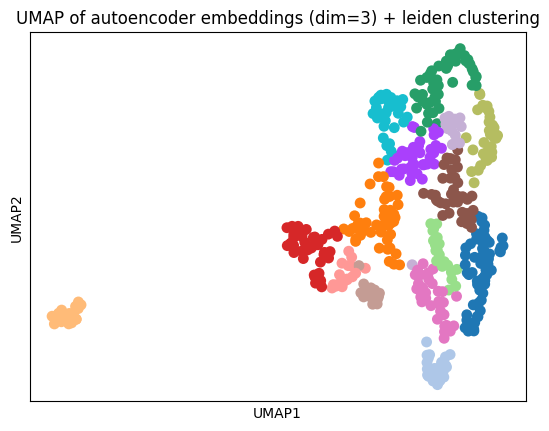

In [110]:
plot_umap(model4_results, 'UMAP of autoencoder embeddings (dim=3) + leiden clustering', 'autoencoder_3.png')

# Test data

In [111]:
adata = an.read_h5ad('all_mouse_forJuju.h5ad')
adata_labels = pd.read_csv('metadata_all_mouse_forJuju.csv')

adata.obs = adata_labels

/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [112]:
adata_no_train = adata[adata.obs["chip"] != "chip19894"].copy()
adata_no_train.obs["batch"] = adata_no_train.obs["batch"].astype(str)

/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [113]:
adata.obs["chip"].nunique()

7

In [114]:
adata_no_train_dataset = EphysDataset(adata_no_train.X, normalize=False)

In [115]:
test_loader = DataLoader(adata_no_train_dataset, batch_size=8)

In [116]:
next(iter(test_loader)).var()

tensor(0.0200)

In [117]:
def get_val_error(model, dataloader):
    val_results = []
    for sample in dataloader:
        output = model(sample, interpolate=False).mean(1)
        val_results.append(output)
        
    avg_loss = torch.cat(val_results).mean()

    return avg_loss


In [118]:
test_results = get_results(model, test_loader)
test_results_smaller = get_results(model_smaller, test_loader)
test_results_tiny = get_results(model_tiny, test_loader)
test_results_mini = get_results(model_mini, test_loader)

Compressed dim is 25
Compressed dim is 12
Compressed dim is 6
Compressed dim is 3


In [119]:
def plot_umap_smalldist(results, title, savepath=None, color='leiden'):
    sc.pp.neighbors(results)
    sc.tl.leiden(results, resolution=0.3)

    sc.tl.umap(results, min_dist=0.35, random_state=42, n_components=2)
    sc.pl.umap(
        results, 
        color=color, 
        title=title, 
        save=savepath if savepath is not None else None, 
        components='all',
        legend_loc=None,
    )


/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


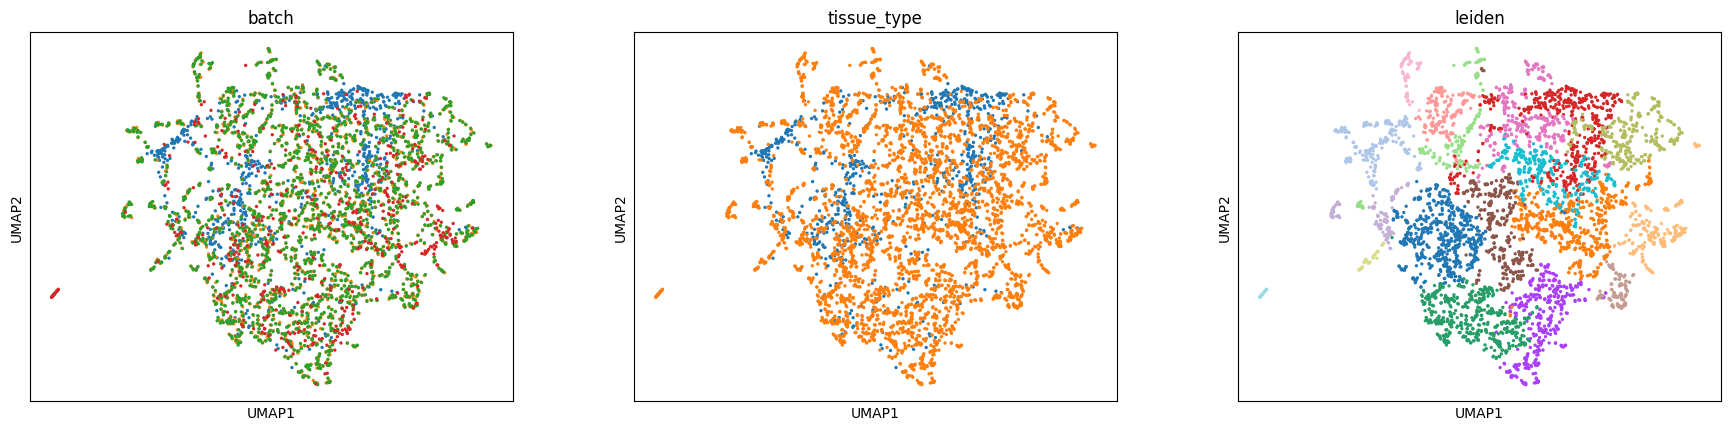

In [120]:
plot_umap_smalldist(
    an.AnnData(test_results, obs=adata_no_train.obs), 
    None,
    "test_results.png",
    ["batch", "tissue_type", "leiden"]
)

/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


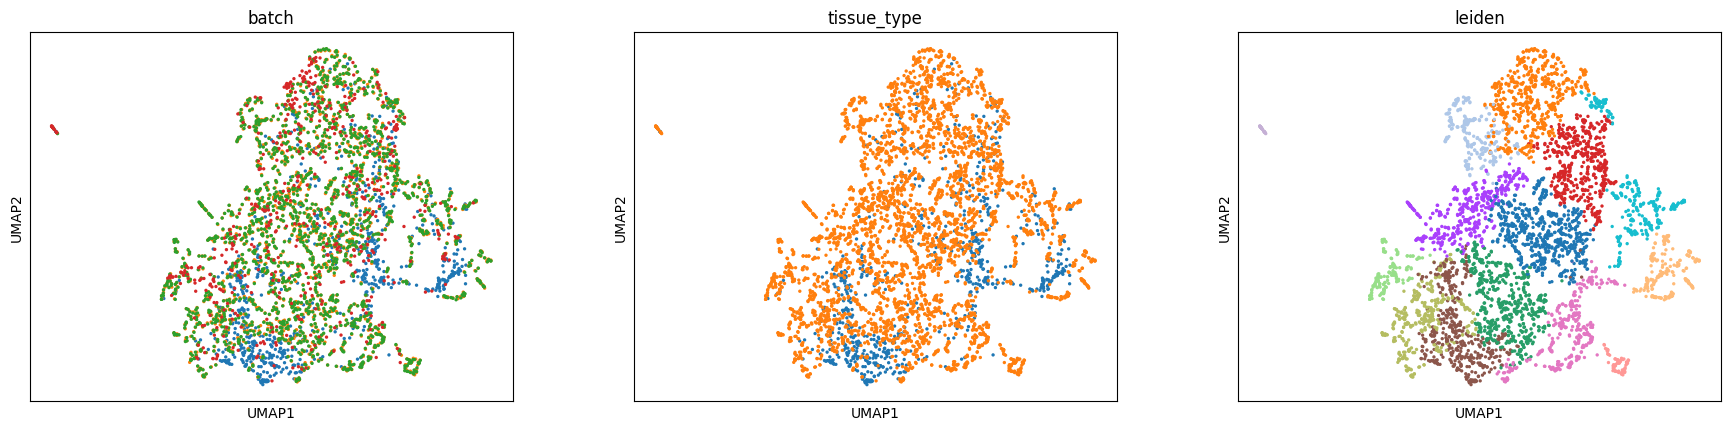

In [121]:
plot_umap_smalldist(
    an.AnnData(test_results_smaller, obs=adata_no_train.obs), 
    None,
    "test_results_smaller.png",
    ["batch", "tissue_type", "leiden"]
)

/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


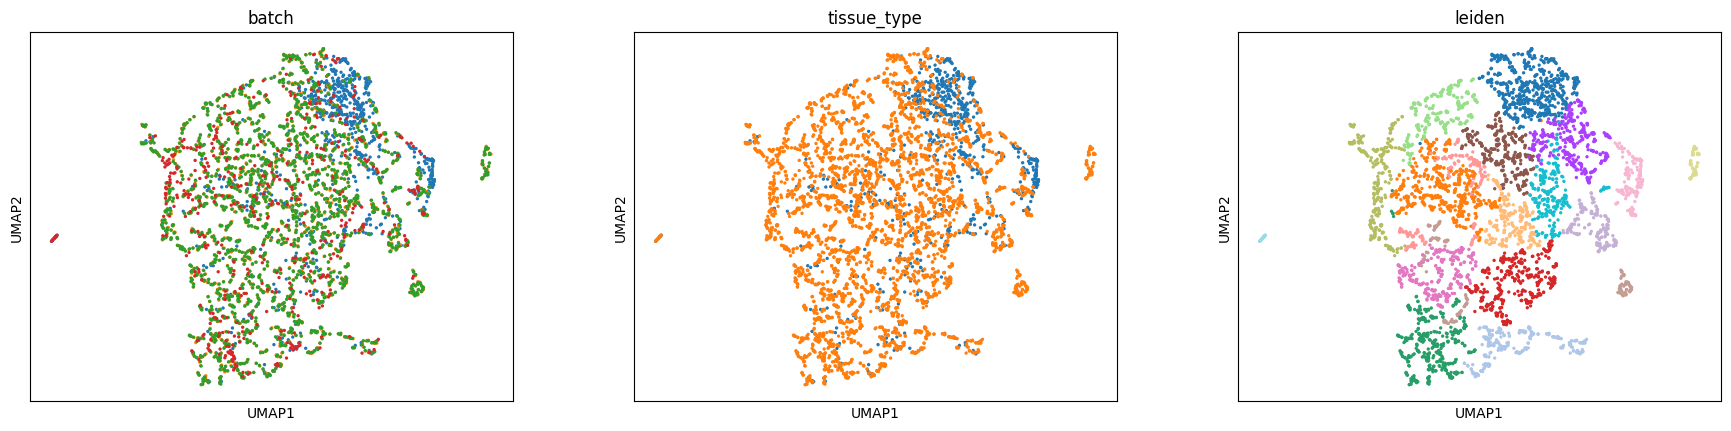

In [122]:
plot_umap_smalldist(
    an.AnnData(test_results_tiny, obs=adata_no_train.obs), 
    None,
    "test_results_tiny.png",
    ["batch", "tissue_type", "leiden"]
)

/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/julian/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


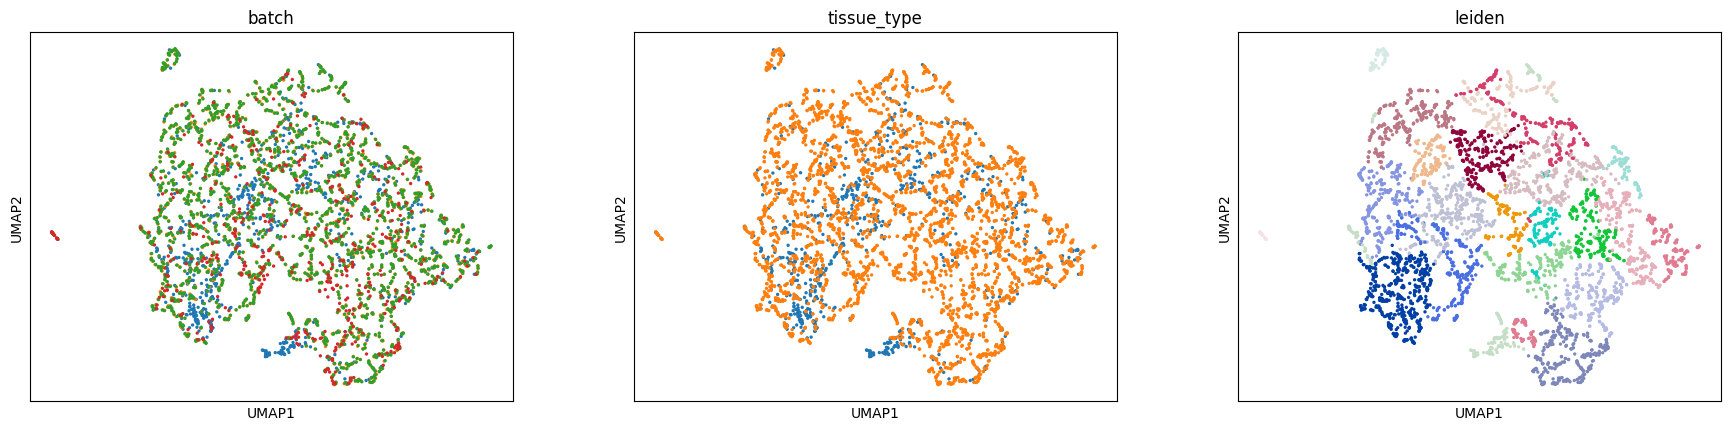

In [123]:
plot_umap_smalldist(
    an.AnnData(test_results_mini, obs=adata_no_train.obs), 
    None,
    "test_results_mini.png",
    ["batch", "tissue_type", "leiden"]
)

In [128]:
def visualize_reconstructed(model, dataloader):
    reconstructed = []
    original = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            reconstructed.extend(model(batch).squeeze(1))
            original.extend(batch.squeeze(1))
    
    reconstructed = torch.stack((reconstructed), 0).detach().numpy()[0:36, :]
    original = torch.stack((original), 0).detach().numpy()[0: 36, :]
    
    return reconstructed, original 

original, reconstructed = visualize_reconstructed(model_smaller, test_loader)



In [129]:
original.shape, reconstructed.shape

((36, 50), (36, 50))

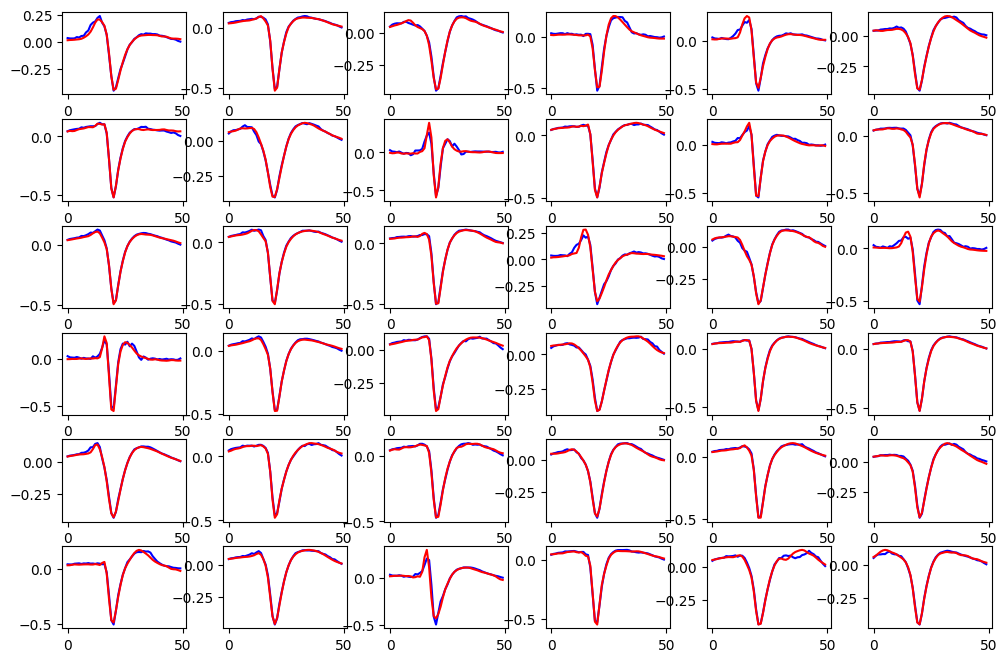

In [134]:
import matplotlib.pyplot as plt

N, M = original.shape

# Determine the number of rows and columns for the grid
num_rows = int(np.ceil(N**0.5))
num_cols = int(np.ceil(N / num_rows))

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array if it's not already 1D
if axs.ndim > 1:
    axs = axs.flatten()

for i in range(N):
    row = i // num_cols
    col = i % num_cols
    # Plot original in blue
    axs[i].plot(original[i], color='blue', label='Original')
    # Plot reconstructed in red
    axs[i].plot(reconstructed[i], color='red', label='Reconstructed')
#     axs[i].set_title(f"Sample {i}")
    # Put legend on the left
#     if col == 0 and i == 0:
#         axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Remove any empty subplots
for j in range(N, num_rows * num_cols):
    fig.delaxes(axs[j])

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots
plt.show()


In [ ]:
# sc.pp.pca(adata_no_train)
# sc.pp.neighbors(adata_no_train, n_pcs=30)
# sc.tl.leiden(adata_no_train)

# sc.tl.umap(adata_no_train, min_dist=0.35, random_state=42, n_components=2)
# sc.pl.umap(
#     adata_no_train, 
#     color=["batch", "tissue_type", "leiden"], 
#     title="intial data ", 
#     components='all',
#     legend_loc=None,
# )

Silhoutte score is 0.1041264533996582
